# レポート AI-2: （広義の）最良優先探索

- レポートの執筆にあたっては，[Moodleのガイダンス資料 > 提出物](https://moodle.el.okayama-u.ac.jp/mod/book/view.php?id=1228167&chapterid=10912)も参考にしてください．
- PDFを作成する際は，↑のLaTeXコードのセルの修正も忘れないように．
- セルはある程度自由に追加しても構いません．

<!-- このセルはPDF化した際に消える設定になっています． -->

**本レポート共通の実験条件**
    
    - 使用機材（番号）
      - PC: S067, Ryzen 5 PRO 5650G
    - 動作確認時の実行環境
      - Python version 3.12.3 (main, Aug 14 2025, 17:47:21) [GCC 13.3.0]
      - Numpy version 2.3.2
      - Matplotlib version 3.10.5
      - NetworkX version 3.5


# A) 考察課題の問い

迷路探索のためのグラフ探索として，Dijkstra’s algorithm の実装をおこない，その実装や実装方針について考察せよ．  
このとき，「深さ優先探索」あるいは「幅優先探索」のいずれかとの差分に注目し，探索過程や探索結果等も示しながら，考察すること．

# B) 解答方針



AI-1で作成した幅優先探索のコードをベースにして，Dijkstra’s algorithm を作成する．ヒープというデータ構造について検討し，Dijkstra’s algorithm に落とし込むために条件付けの方法を学ぶ．その後，実際に幅優先探索のコードに適応して動作させる．
幅優先探索との違いを確認するためにも，ゴールに遠回りでたどり着く経路が最適解のグラフも使って考えてみる．

C-1)では Dijkstra’s algorithm について考察し，C-2)では経路が変更されたグラフへ適用させる．

# C) プログラムの作成

In [4]:
# 本実験でほぼ毎回利用するライブラリ
import sys
import numpy as np

import IPython.display
from IPython.display import display, Markdown

import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams["savefig.bbox"] = 'tight'

# データ構造の定義に利用する
from collections import deque
from dataclasses import dataclass

# グラフ構造の描画に利用するライブラリ
import networkx as netx

#
# DEBUG
#
print('*** System Information ***')
print(f'Python     : {sys.version}')
print(f'NumPy      : {np.__version__}')
print(f'Matplotlib : {matplotlib.__version__}')
print(f'NetworkX   : {netx.__version__}')

*** System Information ***
Python     : 3.12.3 (main, Aug 14 2025, 17:47:21) [GCC 13.3.0]
NumPy      : 2.3.2
Matplotlib : 3.10.5
NetworkX   : 3.5


In [5]:
%reload_ext autoreload
%autoreload 1
%aimport ebai

# 人工知能実験用の補助関数を定義したサブライブラリ（改変不可）
import ebai
ebai.ebai_info()

/home/users/ecs/09B23523/exp-b/ai/ebai.py
> Revision 2025.1
> 更新日時：2025-10-03 11:18:05.715802
>
> Python     : 3.12.3 (main, Aug 14 2025, 17:47:21) [GCC 13.3.0]
> NumPy      : 2.3.2
> Matplotlib : 3.10.5
> NetworkX   : 3.5


In [6]:
# PNGかPDFで画像を出力する
# - レポートPDFを作るときに，どうしても画像サイズが10 MB超える！という場合は，
#   ('png', 'pdf') を ('jpeg') のみに置き換えてから，試してみてください．
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

## C1) Dijkstra’s algorithm 

### ソースコード

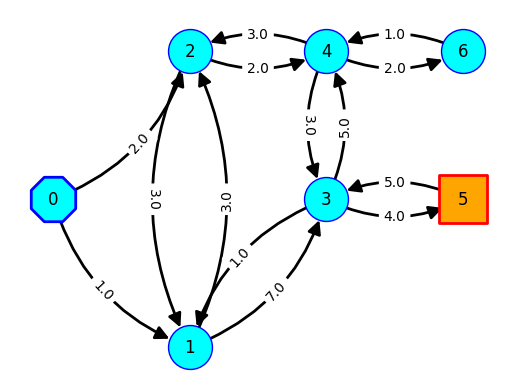

In [4]:
import heapq
@dataclass
class State:
    id: int
    cost: float
    parent_id: int

    # <を使うための定義
    def __lt__(a, b):
        if a.cost != b.cost:
            return a.cost < b.cost

graph4_edgedict = {
    0: [(1, 1.0), (2, 2.0)],
    1: [(2, 3.0), (3, 7.0)],
    2: [(1, 3.0), (4, 2.0)],
    3: [(1, 1.0), (4, 5.0), (5, 4.0)],
    4: [(2, 3.0), (3, 3.0), (6, 2.0)],
    5: [(3, 5.0)],
    6: [(4, 1.0)]
}
graph4_target = 5
graph4_pos = {0: [0, 1], 1: [1, 2], 2: [1, 0], 3: [2, 1], 4:[2, 0], 5:[3, 1], 6: [3, 0]}


fig4, ax4 = plt.subplots()
ebai.draw_graph_structure(graph4_edgedict, graph4_pos, graph4_target, show_weight=True, ax=ax4)

(1) open_list=[State(id=0, cost=0, parent_id=-1)]
(1) closed_list={}

----- LOOP = 1
(3) cur_state=State(id=0, cost=0, parent_id=-1)
(3) open_list=[]
(4) closed_list={0: State(id=0, cost=0, parent_id=-1)}
(6) candidate_state_nodes=[(1, 1.0), (2, 2.0)]
(7) open_list=[State(id=1, cost=1.0, parent_id=0), State(id=2, cost=2.0, parent_id=0)]

----- LOOP = 2
(3) cur_state=State(id=1, cost=1.0, parent_id=0)
(3) open_list=[State(id=2, cost=2.0, parent_id=0)]
(4) closed_list={0: State(id=0, cost=0, parent_id=-1), 1: State(id=1, cost=1.0, parent_id=0)}
(6) candidate_state_nodes=[(2, 3.0), (3, 7.0)]
(7) open_list=[State(id=2, cost=2.0, parent_id=0), State(id=3, cost=8.0, parent_id=1)]

----- LOOP = 3
(3) cur_state=State(id=2, cost=2.0, parent_id=0)
(3) open_list=[State(id=3, cost=8.0, parent_id=1)]
(4) closed_list={0: State(id=0, cost=0, parent_id=-1), 1: State(id=1, cost=1.0, parent_id=0), 2: State(id=2, cost=2.0, parent_id=0)}
(6) candidate_state_nodes=[(1, 3.0), (4, 2.0)]
(7) open_list=[State(

{0: State(id=0, cost=0, parent_id=-1),
 1: State(id=1, cost=1.0, parent_id=0),
 2: State(id=2, cost=2.0, parent_id=0),
 4: State(id=4, cost=4.0, parent_id=2),
 6: State(id=6, cost=6.0, parent_id=4),
 3: State(id=3, cost=7.0, parent_id=4),
 5: State(id=5, cost=11.0, parent_id=3)}

TEST BACKTRACKING --------
DEBUG: bt_node_id=5
DEBUG: route=deque([5])
DEBUG: bt_node_id=3
DEBUG: route=deque([3, 5])
DEBUG: bt_node_id=4
DEBUG: route=deque([4, 3, 5])
DEBUG: bt_node_id=2
DEBUG: route=deque([2, 4, 3, 5])
DEBUG: bt_node_id=0
DEBUG: route=deque([0, 2, 4, 3, 5])
DEBUG: bt_node_id=-1
Backtracking: Success: Route = [0, 2, 4, 3, 5]

-----


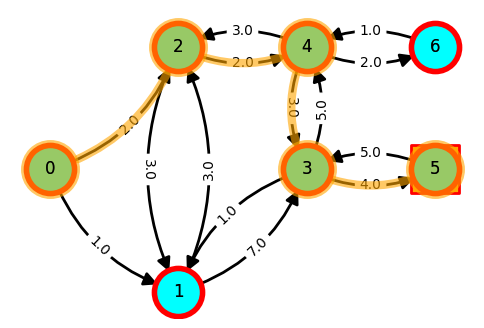

In [5]:
graph_edgedict = graph4_edgedict
graph_target = graph4_target
graph_pos = graph4_pos

# Write your code
# (1) Initialization
# (1-1) Prepare open_list as STACK, QUEUE, or XXXX(AI-2)
open_list = []
heapq.heapify(open_list)
# - 任意のリストは heapify を経ることで heap として扱えるようになります．
heapq.heappush(open_list, State(0, cost=0, parent_id=-1))
    # - open_list は "List(deque) of State" とする．
    #   - [] の中に State() を1つだけ入れており，そのリストで deque を初期化している．
    # - スタートは常に0番ノードにする．
    #   - いったんはcost = 0, parent_id = -1 ということにしておく．
    #   - 【重要】cost と parent_id は後で見直しが必要．

# (1-2) Prepare closed_list as DICT
closed_list = dict()
    # - closed_list は "Dict of State" とする．
    # - cf. This implementaion by dict might be easy and simple one.
    #       However, an implementation by list (static table) might
    #       be faster. As some algorithm contest, the dict implementation
    #       will be caused TLE (Time Limit Exceed)...

# DEBUG
print(f'(1) {open_list=}')
print(f'(1) {closed_list=}')


# ---------------------------------------------------------------------------
# (2) Loop until the open_list is empty
#     (Loop while(if) the open_list is not empty)
loop_count = 0
while len(open_list) > 0 and loop_count < 100:
    # - open_listに要素がある限り，ループし続ける
    # - 安全のため，loop_count が増えすぎてるなら，タイムアウトとして止める．
    #   **初期の100では，探索対象のグラフによっては少なすぎるかもしれないので，注意．**
    # - なお，例年 while 文が苦手という人がいるようですが・・・
    #   while文は，if文とほぼ同じです．条件が成立するなら内部を実行する，です．
    #   ただし，if文は内部を実行終えたら，そこで終わるが，while文は条件判定に戻る．
    #   cf. アセンブラで言えば，if でも while でも，beqによる条件分岐があるのは同じだが，
    #       while は最後に j whie_loop を置くことでループ構造を実現する．
    #       https://www.swlab.cs.okayama-u.ac.jp/~nom/lect/p3/dat/examples/ans-practice5-1.s 

    loop_count += 1;
    print(f'\n----- LOOP = {loop_count}')

    # -----------------------------------------------------------------------
    # (3) Set current state for search algorithm
    cur_state = heapq.heappop(open_list)   # POP as STACK

    #     DEBUG
    print(f'(3) {cur_state=}')
    print(f'(3) {open_list=}')

    # -----------------------------------------------------------------------
    # (4) Update closed_list
    assert cur_state.id not in closed_list, f'REVISITED: {cur_state.id=} should not in {closed_list=}'
        # - assert は条件を満たしていないときに処理を止める関数です
        #   - アルゴリズムとして必要なのではなく，検証 (validation) の一種です．
        # - 後述の (7-1) や (7-2) で適切な処理をしていない場合は，
        #   ここで "再訪(revisit)" してしまう場合があります．
        #   - "再訪" になってしまう場合は，ここで処理を加えるよりは (7) を見直しましょう．
        # - ただし・・・どうしても解決できない（か，独自に考えているアルゴリズムであり，
        #   ここでの再訪相当を適切に処理することにした）なら，この assert を除いてください．
        #   - それはそれで，考察できることは増えると思いますので．．．

    closed_list[cur_state.id] = cur_state
        # - closed_list に記録を残します．
        # - 本講義で想定しているアルゴリズムであれば，ここでは上書きは起こりません．
        #   - 上述の通り，アルゴリズムによっては，何らかの条件分岐が必要かもしれません．

    #     DEBUG
    print(f'(4) {closed_list=}')

    # -----------------------------------------------------------------------
    # (5) Check whether reaching the target (goal) or not
    if graph_target in closed_list:
        # Python の独特な条件式です．graph_target と一致する要素が，
        # closed_list のキーに含まれているかどうかのチェックをしています．

        print('\n**** I have reached the target node!!\n')
        break
            # この終了条件は，今後必要に応じて見直しが必要になるでしょう．
            # 【発展】ここで終了しなくても，解説A3の経路探索は実現できる．
            #         （終了すべきでない，とまでは言っていません．考察課題です．）

    # -----------------------------------------------------------------------
    # (6) Find adjacent nodes
    candidate_state_nodes = graph_edgedict[cur_state.id]
        # - cur_stateのノードの隣接ノードは，graph_edgedict を辞書引きすればよい
        # - この時点では candidate_state_nodes は (dst_id, weight) のタプルである．

    #     DEBUG
    print(f'(6) {candidate_state_nodes=}')

    # -----------------------------------------------------------------------
    # (7) Update open_list
    for _dst_id, _weight in candidate_state_nodes:
        candidate_state = State(
            id=_dst_id,
            cost=_weight + cur_state.cost,       # TODO: 解説A5 & A6 (AI-2)
            parent_id=cur_state.id  # TODO: 解説A3
        )
            # - for ループを使い，候補となるノードを追加したい．効率は無視．
            #   - 候補となるノードは，[解説A2]時点では，id (ノードID)しか情報を持っていない．
            #   - parent_id は，次の[解説A3]で考え直す必要がある．
            #   - cost は，AI-2で考え直す必要がある．
            # - 以降，_candidate_node を open_list に追加してよいかどうか，
            #   を判定してから，最終的に，open_list へ追加する．

        # (7-1) Ignore the candidate, if it existing in closed _list
        #   Note: We should reconsider this process, if try to implement A* algorithm
        if candidate_state.id in closed_list:
            continue
                # - closed_list は dict 型なので in 演算子で存在の判定ができる
                # - _dst_id が探索済みのノード（closed_list内のノード）である
                #    ==> open_listには追加しない．
                #    ==> "continue" により，以降の処理は実行せず，forループを継続する

        # (7-2) Ignore the candidate, if it existing in open_list
        #   Note: We must reconsider this process at AI-2
        _exist_state = [x for x in open_list if x.id == candidate_state.id]
        _exist_state = _exist_state[0] if _exist_state else None
        if _exist_state is None:
                # - 本講義だけでは，この3行の条件判定の解説は難しいので，深入りしないで構いません．
                # - この処理では，open_list 内の全探索状態に candidate_state.id と同じIDがあれば，
                #   _exist_state として，open_list の1要素が得られます．無ければ None です．

            heapq.heappush(open_list, candidate_state)

        elif candidate_state.cost < _exist_state.cost:
            open_list.remove(_exist_state)
            open_list.append(candidate_state)
            heapq.heapify(open_list)
        else:
            pass
                # - open_list に _dst_id と同じ id の状態データが存在する
                #    ==> (AI-1では) open_listには追加しない．
                #
                # 【重要】AI-2で cost も踏まえた再検討をする．次回のTutorial 3 も注意深く確認しよう．

    print(f'(7) {open_list=}')

# -----------------------------------------------------------------------


#
# Backtracking
#
def backtrack(closed_list, graph_target, graph_start):
    """ BACKTRACK
    PARAMETERS
    ----------
    closed_list
        グラフ探索で得られたクローズドリスト
    graph_target
        グラフ探索におけるゴールとなるノードのID
    graph_start (default: 0)
        グラフ探索におけるスタートとなるノードのID

    RETURNS
    -------
    ????
        ????
    ????
        ????

    NOTE
    ----
    - return は各自で考えよう．
      - 何も戻さない方針なら return 文をなくして，上記 RETURNS については，None とでも書いておけばよい
    """
    # parameters
    route = deque([])
        # - route にノード情報を追加していく．
        # - 追加と利用の考え方は，システムプログラミングの関数呼び出しにおけるスタックと同じ考え方．
    
    bt_node_id = graph_target
        # - ゴールから逆にたどるので，ゴールのノード番号を入れておく
        # - bt は backtracking の略です．
    
    # Debug
    print(f'DEBUG: {bt_node_id=}')
    while bt_node_id >= 0:
        # - 本資料では，ソースノードは，常に0番ノードと仮定していることを思い出そう．
        #   - ソースノードは，Backtracking 処理におけるゴールに相当する．
        # - != 0 でも問題はないが・・・もう少し考えてみよう
        #   - 実際のところ，（正常な）ノードID としては，正の値しか使っていない．
        #   - そこで，先を見越して，広く設定しておこう．この条件ならば「正常でない」の意味で，
        #     マイナス番号のノードIDをプログラマが意図的に利用することもできる．
    
        route.appendleft(bt_node_id)
            # - 先頭に追加していく．
    
        # Debug
        print(f'DEBUG: {route=}')
    
        bt_node_id = closed_list.get(bt_node_id, State(id=-1, cost=-1, parent_id=-9)).parent_id
            # - dict.getは，辞書引きをする際にkeyが見つからなければ，第2引数をdefault値としてを返す
    
        # Debug
        print(f'DEBUG: {bt_node_id=}')
    
    if bt_node_id <= graph_start:
            # ⇒ a) Backtracking 成功は，どんな条件になるでしょうか？
            #   自分でif文を書き換えてください．
        # Backtracking 成功
        print(f'Backtracking: Success: Route = {list(route)}')
    else:
        # Backtracking失敗
        print(f'Backtracking: Failed: Route = {list(route)}?')

    # Debug
    print('\n-----')

    return list(route)
            # ⇒ b) 何を返すのがよいか，は自分でよく考えてください．
            #       （何も返さないという方針も当然あり得ますが，考えを示す必要があります．）

#
# Test your function
#
print(f'DEBUG: {graph_target=}')
display(closed_list)
    # - 探索"成功"時の closed_list を使います．セルの中でも，簡単に中身を確認しておくといいでしょう．
    # - なお，"成功"していないときの動作は，未定義です．所望のBacktrackingの結果は得られないでしょう．

print('TEST BACKTRACKING --------')
true_rute = backtrack(closed_list, graph_target, 0)
    # - 関数のデバッグをしたいなら，右サイドバーの虫アイコンを押して，デバッガを起動し，
    #   ブレークポイント設置とステップ実行をするとよいでしょう．

# DEBUG: draw the Graph
ebai.draw_graph_structure(graph_edgedict, graph_pos, graph_target, open_list=open_list,
                          show_weight=True,
                          highlight_path=true_rute,
                          closed_list=closed_list)
    # - 先ほどの描画例に加えて，open_list, closed_list も追加している
    #   - 適宜，引数を与えずに描画するなどして，描かれた図の各シンボルが
    #     何を表しているのか，理解をしてください．
    # - ループ込みの完成版であれば，ループ内で毎回描画するのは，無駄である．
    #   必要な場所でのみ，描画すれば十分であろう．
    # **********
    # 【注意】
    # fig?.savefig()を利用した画像保存をする際は，十分に注意を払ってください．
    # ループ内での savefig() 呼び出しは，大量のネットワーク経由のデータ転送と，
    # 共有ディスクの大量消費をする可能性があり，ほかの学生の受講の妨げになります．
    # （あなたの端末だけでなく，演習室の全端末がハングアップする可能性があります．）
    # **********

# Show the Result of Backtracking

### 実行結果に対する説明と考察

グラフの矢印の中心にある数値はそのルートにおける重みである． DEBUG として出力されている State の cost を見てみると，親ノードまでの cost も加算されている．赤くなっているのは探索されたノードであり，オレンジ色で光っている経路が Dijkstra’s algorithm によって導出された最短経路である．合計コストの小さい順に探索を勧めていくことにより，最小コストで探索を終了することができる．

使用するデータ構造はユニーク制約付きの優先度付きキューである．これはデータをヒープで管理するものである． cost が小さい順になるように木構造が組まれる．このときの木構造は [ 親ノード < 子ノード ] という関係のみが担保されている木構造であるため，木構造の根となる open_list の先頭データのみを扱うことによって常に最小のデータを扱うことができるようになっている．

またユニーク制約付きというのは，先に優先度付きキューにエンキューした id についても，新しく出てきた同じ id のデータの cost が以前の cost よりも小さければ上書きするというものである．


## C2) 遠回りな経路に対する検討

### ソースコード

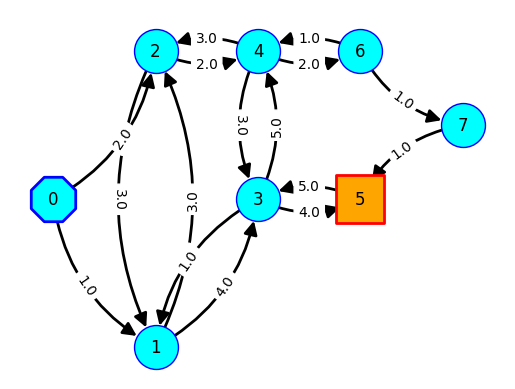

In [6]:
import heapq
@dataclass
class State:
    id: int
    cost: float
    parent_id: int

    # <を使うための定義
    def __lt__(a, b):
        if a.cost != b.cost:
            return a.cost < b.cost

graph4_edgedict = {
    0: [(1, 1.0), (2, 2.0)],
    1: [(2, 3.0), (3, 4.0)],
    2: [(1, 3.0), (4, 2.0)],
    3: [(1, 1.0), (4, 5.0), (5, 4.0)],
    4: [(2, 3.0), (3, 3.0), (6, 2.0)],
    5: [(3, 5.0)],
    6: [(4, 1.0), (7, 1.0)],
    7: [(5, 1.0)]
}
graph4_target = 5
graph4_pos = {0: [0, 1], 1: [1, 2], 2: [1, 0], 3: [2, 1], 4:[2, 0], 5:[3, 1], 6: [3, 0], 7: [4, 0.5]}

fig4, ax4 = plt.subplots()
ebai.draw_graph_structure(graph4_edgedict, graph4_pos, graph4_target, show_weight=True, ax=ax4)

(1) open_list=[State(id=0, cost=0, parent_id=-1)]
(1) closed_list={}

----- LOOP = 1
(3) cur_state=State(id=0, cost=0, parent_id=-1)
(3) open_list=[]
(4) closed_list={0: State(id=0, cost=0, parent_id=-1)}
(6) candidate_state_nodes=[(1, 1.0), (2, 2.0)]
(7) open_list=[State(id=1, cost=1.0, parent_id=0), State(id=2, cost=2.0, parent_id=0)]

----- LOOP = 2
(3) cur_state=State(id=1, cost=1.0, parent_id=0)
(3) open_list=[State(id=2, cost=2.0, parent_id=0)]
(4) closed_list={0: State(id=0, cost=0, parent_id=-1), 1: State(id=1, cost=1.0, parent_id=0)}
(6) candidate_state_nodes=[(2, 3.0), (3, 4.0)]
(7) open_list=[State(id=2, cost=2.0, parent_id=0), State(id=3, cost=5.0, parent_id=1)]

----- LOOP = 3
(3) cur_state=State(id=2, cost=2.0, parent_id=0)
(3) open_list=[State(id=3, cost=5.0, parent_id=1)]
(4) closed_list={0: State(id=0, cost=0, parent_id=-1), 1: State(id=1, cost=1.0, parent_id=0), 2: State(id=2, cost=2.0, parent_id=0)}
(6) candidate_state_nodes=[(1, 3.0), (4, 2.0)]
(7) open_list=[State(

{0: State(id=0, cost=0, parent_id=-1),
 1: State(id=1, cost=1.0, parent_id=0),
 2: State(id=2, cost=2.0, parent_id=0),
 4: State(id=4, cost=4.0, parent_id=2),
 3: State(id=3, cost=5.0, parent_id=1),
 6: State(id=6, cost=6.0, parent_id=4),
 7: State(id=7, cost=7.0, parent_id=6),
 5: State(id=5, cost=8.0, parent_id=7)}

TEST BACKTRACKING --------
DEBUG: bt_node_id=5
DEBUG: route=deque([5])
DEBUG: bt_node_id=7
DEBUG: route=deque([7, 5])
DEBUG: bt_node_id=6
DEBUG: route=deque([6, 7, 5])
DEBUG: bt_node_id=4
DEBUG: route=deque([4, 6, 7, 5])
DEBUG: bt_node_id=2
DEBUG: route=deque([2, 4, 6, 7, 5])
DEBUG: bt_node_id=0
DEBUG: route=deque([0, 2, 4, 6, 7, 5])
DEBUG: bt_node_id=-1
Backtracking: Success: Route = [0, 2, 4, 6, 7, 5]

-----


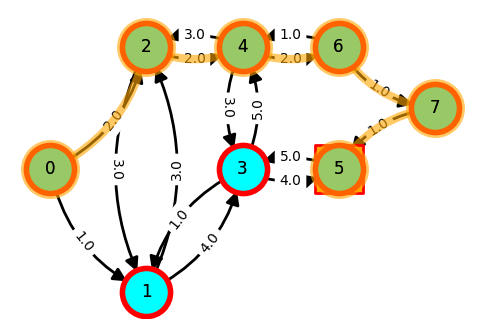

In [7]:
graph_edgedict = graph4_edgedict
graph_target = graph4_target
graph_pos = graph4_pos

# Write your code
# (1) Initialization
# (1-1) Prepare open_list as STACK, QUEUE, or XXXX(AI-2)
open_list = []
heapq.heapify(open_list)
# - 任意のリストは heapify を経ることで heap として扱えるようになります．
heapq.heappush(open_list, State(0, cost=0, parent_id=-1))
    # - open_list は "List(deque) of State" とする．
    #   - [] の中に State() を1つだけ入れており，そのリストで deque を初期化している．
    # - スタートは常に0番ノードにする．
    #   - いったんはcost = 0, parent_id = -1 ということにしておく．
    #   - 【重要】cost と parent_id は後で見直しが必要．

# (1-2) Prepare closed_list as DICT
closed_list = dict()
    # - closed_list は "Dict of State" とする．
    # - cf. This implementaion by dict might be easy and simple one.
    #       However, an implementation by list (static table) might
    #       be faster. As some algorithm contest, the dict implementation
    #       will be caused TLE (Time Limit Exceed)...

# DEBUG
print(f'(1) {open_list=}')
print(f'(1) {closed_list=}')


# ---------------------------------------------------------------------------
# (2) Loop until the open_list is empty
#     (Loop while(if) the open_list is not empty)
loop_count = 0
while len(open_list) > 0 and loop_count < 100:
    # - open_listに要素がある限り，ループし続ける
    # - 安全のため，loop_count が増えすぎてるなら，タイムアウトとして止める．
    #   **初期の100では，探索対象のグラフによっては少なすぎるかもしれないので，注意．**
    # - なお，例年 while 文が苦手という人がいるようですが・・・
    #   while文は，if文とほぼ同じです．条件が成立するなら内部を実行する，です．
    #   ただし，if文は内部を実行終えたら，そこで終わるが，while文は条件判定に戻る．
    #   cf. アセンブラで言えば，if でも while でも，beqによる条件分岐があるのは同じだが，
    #       while は最後に j whie_loop を置くことでループ構造を実現する．
    #       https://www.swlab.cs.okayama-u.ac.jp/~nom/lect/p3/dat/examples/ans-practice5-1.s 

    loop_count += 1;
    print(f'\n----- LOOP = {loop_count}')

    # -----------------------------------------------------------------------
    # (3) Set current state for search algorithm
    cur_state = heapq.heappop(open_list)   # POP as STACK

    #     DEBUG
    print(f'(3) {cur_state=}')
    print(f'(3) {open_list=}')

    # -----------------------------------------------------------------------
    # (4) Update closed_list
    assert cur_state.id not in closed_list, f'REVISITED: {cur_state.id=} should not in {closed_list=}'
        # - assert は条件を満たしていないときに処理を止める関数です
        #   - アルゴリズムとして必要なのではなく，検証 (validation) の一種です．
        # - 後述の (7-1) や (7-2) で適切な処理をしていない場合は，
        #   ここで "再訪(revisit)" してしまう場合があります．
        #   - "再訪" になってしまう場合は，ここで処理を加えるよりは (7) を見直しましょう．
        # - ただし・・・どうしても解決できない（か，独自に考えているアルゴリズムであり，
        #   ここでの再訪相当を適切に処理することにした）なら，この assert を除いてください．
        #   - それはそれで，考察できることは増えると思いますので．．．

    closed_list[cur_state.id] = cur_state
        # - closed_list に記録を残します．
        # - 本講義で想定しているアルゴリズムであれば，ここでは上書きは起こりません．
        #   - 上述の通り，アルゴリズムによっては，何らかの条件分岐が必要かもしれません．

    #     DEBUG
    print(f'(4) {closed_list=}')

    # -----------------------------------------------------------------------
    # (5) Check whether reaching the target (goal) or not
    if graph_target in closed_list:
        # Python の独特な条件式です．graph_target と一致する要素が，
        # closed_list のキーに含まれているかどうかのチェックをしています．

        print('\n**** I have reached the target node!!\n')
        break
            # この終了条件は，今後必要に応じて見直しが必要になるでしょう．
            # 【発展】ここで終了しなくても，解説A3の経路探索は実現できる．
            #         （終了すべきでない，とまでは言っていません．考察課題です．）

    # -----------------------------------------------------------------------
    # (6) Find adjacent nodes
    candidate_state_nodes = graph_edgedict[cur_state.id]
        # - cur_stateのノードの隣接ノードは，graph_edgedict を辞書引きすればよい
        # - この時点では candidate_state_nodes は (dst_id, weight) のタプルである．

    #     DEBUG
    print(f'(6) {candidate_state_nodes=}')

    # -----------------------------------------------------------------------
    # (7) Update open_list
    for _dst_id, _weight in candidate_state_nodes:
        candidate_state = State(
            id=_dst_id,
            cost=_weight + cur_state.cost,       # TODO: 解説A5 & A6 (AI-2)
            parent_id=cur_state.id  # TODO: 解説A3
        )
            # - for ループを使い，候補となるノードを追加したい．効率は無視．
            #   - 候補となるノードは，[解説A2]時点では，id (ノードID)しか情報を持っていない．
            #   - parent_id は，次の[解説A3]で考え直す必要がある．
            #   - cost は，AI-2で考え直す必要がある．
            # - 以降，_candidate_node を open_list に追加してよいかどうか，
            #   を判定してから，最終的に，open_list へ追加する．

        # (7-1) Ignore the candidate, if it existing in closed _list
        #   Note: We should reconsider this process, if try to implement A* algorithm
        if candidate_state.id in closed_list:
            continue
                # - closed_list は dict 型なので in 演算子で存在の判定ができる
                # - _dst_id が探索済みのノード（closed_list内のノード）である
                #    ==> open_listには追加しない．
                #    ==> "continue" により，以降の処理は実行せず，forループを継続する

        # (7-2) Ignore the candidate, if it existing in open_list
        #   Note: We must reconsider this process at AI-2
        _exist_state = [x for x in open_list if x.id == candidate_state.id]
        _exist_state = _exist_state[0] if _exist_state else None
        if _exist_state is None:
                # - 本講義だけでは，この3行の条件判定の解説は難しいので，深入りしないで構いません．
                # - この処理では，open_list 内の全探索状態に candidate_state.id と同じIDがあれば，
                #   _exist_state として，open_list の1要素が得られます．無ければ None です．

            heapq.heappush(open_list, candidate_state)

        elif candidate_state.cost < _exist_state.cost:
            open_list.remove(_exist_state)
            open_list.append(candidate_state)
            heapq.heapify(open_list)
        else:
            pass
                # - open_list に _dst_id と同じ id の状態データが存在する
                #    ==> (AI-1では) open_listには追加しない．
                #
                # 【重要】AI-2で cost も踏まえた再検討をする．次回のTutorial 3 も注意深く確認しよう．

    print(f'(7) {open_list=}')

# -----------------------------------------------------------------------


#
# Backtracking
#
def backtrack(closed_list, graph_target, graph_start):
    """ BACKTRACK
    PARAMETERS
    ----------
    closed_list
        グラフ探索で得られたクローズドリスト
    graph_target
        グラフ探索におけるゴールとなるノードのID
    graph_start (default: 0)
        グラフ探索におけるスタートとなるノードのID

    RETURNS
    -------
    ????
        ????
    ????
        ????

    NOTE
    ----
    - return は各自で考えよう．
      - 何も戻さない方針なら return 文をなくして，上記 RETURNS については，None とでも書いておけばよい
    """
    # parameters
    route = deque([])
        # - route にノード情報を追加していく．
        # - 追加と利用の考え方は，システムプログラミングの関数呼び出しにおけるスタックと同じ考え方．
    
    bt_node_id = graph_target
        # - ゴールから逆にたどるので，ゴールのノード番号を入れておく
        # - bt は backtracking の略です．
    
    # Debug
    print(f'DEBUG: {bt_node_id=}')
    while bt_node_id >= 0:
        # - 本資料では，ソースノードは，常に0番ノードと仮定していることを思い出そう．
        #   - ソースノードは，Backtracking 処理におけるゴールに相当する．
        # - != 0 でも問題はないが・・・もう少し考えてみよう
        #   - 実際のところ，（正常な）ノードID としては，正の値しか使っていない．
        #   - そこで，先を見越して，広く設定しておこう．この条件ならば「正常でない」の意味で，
        #     マイナス番号のノードIDをプログラマが意図的に利用することもできる．
    
        route.appendleft(bt_node_id)
            # - 先頭に追加していく．
    
        # Debug
        print(f'DEBUG: {route=}')
    
        bt_node_id = closed_list.get(bt_node_id, State(id=-1, cost=-1, parent_id=-9)).parent_id
            # - dict.getは，辞書引きをする際にkeyが見つからなければ，第2引数をdefault値としてを返す
    
        # Debug
        print(f'DEBUG: {bt_node_id=}')
    
    if bt_node_id <= graph_start:
            # ⇒ a) Backtracking 成功は，どんな条件になるでしょうか？
            #   自分でif文を書き換えてください．
        # Backtracking 成功
        print(f'Backtracking: Success: Route = {list(route)}')
    else:
        # Backtracking失敗
        print(f'Backtracking: Failed: Route = {list(route)}?')

    # Debug
    print('\n-----')

    return list(route)
            # ⇒ b) 何を返すのがよいか，は自分でよく考えてください．
            #       （何も返さないという方針も当然あり得ますが，考えを示す必要があります．）

#
# Test your function
#
print(f'DEBUG: {graph_target=}')
display(closed_list)
    # - 探索"成功"時の closed_list を使います．セルの中でも，簡単に中身を確認しておくといいでしょう．
    # - なお，"成功"していないときの動作は，未定義です．所望のBacktrackingの結果は得られないでしょう．

print('TEST BACKTRACKING --------')
true_rute = backtrack(closed_list, graph_target, 0)
    # - 関数のデバッグをしたいなら，右サイドバーの虫アイコンを押して，デバッガを起動し，
    #   ブレークポイント設置とステップ実行をするとよいでしょう．

# DEBUG: draw the Graph
ebai.draw_graph_structure(graph_edgedict, graph_pos, graph_target, open_list=open_list,
                          show_weight=True,
                          highlight_path=true_rute,
                          closed_list=closed_list)
    # - 先ほどの描画例に加えて，open_list, closed_list も追加している
    #   - 適宜，引数を与えずに描画するなどして，描かれた図の各シンボルが
    #     何を表しているのか，理解をしてください．
    # - ループ込みの完成版であれば，ループ内で毎回描画するのは，無駄である．
    #   必要な場所でのみ，描画すれば十分であろう．
    # **********
    # 【注意】
    # fig?.savefig()を利用した画像保存をする際は，十分に注意を払ってください．
    # ループ内での savefig() 呼び出しは，大量のネットワーク経由のデータ転送と，
    # 共有ディスクの大量消費をする可能性があり，ほかの学生の受講の妨げになります．
    # （あなたの端末だけでなく，演習室の全端末がハングアップする可能性があります．）
    # **********

# Show the Result of Backtracking

### 実行結果に対する説明と考察

アルゴリズムには変更を加えていない．実際に適応してみると，想定の最短経路を導出している．


# D) 考察

Dijkstra’s algorithm は幅優先探索のアルゴリズムに重みの計算を付け加えたアルゴリズムである．常に最小のコストとなるように経路を選択してゆく．open_list に記録する際に同じ id に直面したとき，cost が小さければ上書きする．

今回のアルゴリズムにおいてはヒープを用いた実装となっている．この場合，計算量としては O(mlog(n)) (mは辺の数，nは頂点の数) となる．ヒープを使わずにキューで全頂点を探索するアルゴリズムにおいては O(m + n^2) の計算量が必要となる．ここから，[ m < n^2 ] においてはヒープを用いたアルゴリズムのほうが効率が良いとわかる．今回扱った問題では， (m, n^2) = (16, 64) より，効率よく探索できているといえる．


幅優先探索においては，キューに入れられた順番に探索してゆくので C2) のパターンでは， [6, 7] を探索する前にアルゴリズムが終了してしまう．またその経路も， [0, 1, 3, 5] のように高いコストの経路となる．しかしその分，探索にかかる時間は早い．ダイクストラ法では確実な最短経路が求まるが探索に時間がかかる．

# E) 発展課題の検討と考察

## E-1) (Extra-A) グリッド型迷路の利用

### ソースコード

In [7]:
# 本実験でほぼ毎回利用するライブラリ
import sys
import numpy as np

import IPython
import IPython.display
from IPython.display import display, Markdown

import matplotlib
from matplotlib import pyplot as plt  # hoge

# 人工知能実験で利用
from collections import deque
from dataclasses import dataclass
import networkx as netx

#
# DEBUG
#
print('*** System Information ***')
print(f'Python     : {sys.version}')
print(f'NumPy      : {np.__version__}')
print(f'Matplotlib : {matplotlib.__version__}')
print(f'NetworkX   : {netx.__version__}')

*** System Information ***
Python     : 3.12.3 (main, Aug 14 2025, 17:47:21) [GCC 13.3.0]
NumPy      : 2.3.2
Matplotlib : 3.10.5
NetworkX   : 3.5


In [8]:
%reload_ext autoreload
%autoreload 1
%aimport ebai

# 人工知能実験用の補助関数を定義したサブライブラリ（改変不可）
import ebai
ebai.ebai_info()

display(Markdown("**要確認：Revision 2025.1 以上が必要です**"))
    

/home/users/ecs/09B23523/exp-b/ai/ebai.py
> Revision 2025.1
> 更新日時：2025-10-03 11:18:05.715802
>
> Python     : 3.12.3 (main, Aug 14 2025, 17:47:21) [GCC 13.3.0]
> NumPy      : 2.3.2
> Matplotlib : 3.10.5
> NetworkX   : 3.5


**要確認：Revision 2025.1 以上が必要です**

In [9]:
import ipywidgets

#%matplotlib inline
%matplotlib widget
#%matplotlib qt

    # - このセルは少し特殊な意味を持っています．
    #   - inline を指定
    #     - Jupyter Lab の標準の挙動です．入力セルの直下に描画されます．
    #     - inline ではインタラクティブ（対話的）な動作ができません＝(B)は実行不可
    #   - widget (または ipympl)を指定
    #     - Jupyter Lab の output 内に描画されますが，少しリッチな画面になります．
    #   - qt を指定
    #     - plot (subplots) のたびに別ウィンドウが立ち上がります
    # - 標準以外では，描画がおかしくなる可能性もありますので，注意してください．
    #   - Extra-Aまでの内容ならば，このセルはすべてコメントアウトしていても問題ありません．

#
# DEBUG
#
print('*** System Information ***')
print(f'ipywidgets : {ipywidgets.__version__}')  # <-- NEW!!
print(f'{matplotlib.get_backend()=}')
print(f'{matplotlib.rcsetup.all_backends=}')
print(f'{matplotlib.rcsetup.interactive_bk=}')

*** System Information ***
ipywidgets : 8.1.7
matplotlib.get_backend()='widget'
matplotlib.rcsetup.all_backends=['gtk3agg', 'gtk3cairo', 'gtk4agg', 'gtk4cairo', 'macosx', 'nbagg', 'notebook', 'qtagg', 'qtcairo', 'qt5agg', 'qt5cairo', 'tkagg', 'tkcairo', 'webagg', 'wx', 'wxagg', 'wxcairo', 'agg', 'cairo', 'pdf', 'pgf', 'ps', 'svg', 'template']
matplotlib.rcsetup.interactive_bk=['gtk3agg', 'gtk3cairo', 'gtk4agg', 'gtk4cairo', 'macosx', 'nbagg', 'notebook', 'qtagg', 'qtcairo', 'qt5agg', 'qt5cairo', 'tkagg', 'tkcairo', 'webagg', 'wx', 'wxagg', 'wxcairo']


/tmp/ipykernel_10788/324554521.py:24: MatplotlibDeprecationWarning: The all_backends attribute was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use ``matplotlib.backends.backend_registry.list_builtin()`` instead.
  print(f'{matplotlib.rcsetup.all_backends=}')
/tmp/ipykernel_10788/324554521.py:25: MatplotlibDeprecationWarning: The interactive_bk attribute was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use ``matplotlib.backends.backend_registry.list_builtin(matplotlib.backends.BackendFilter.INTERACTIVE)`` instead.
  print(f'{matplotlib.rcsetup.interactive_bk=}')


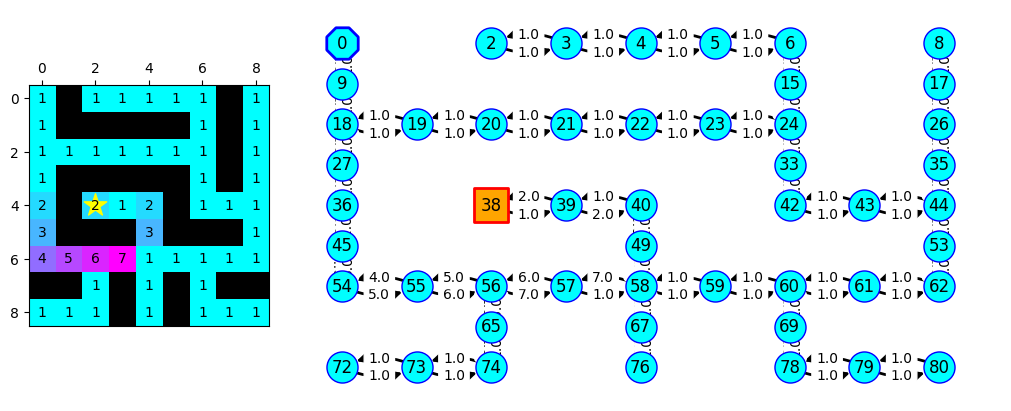

In [10]:
maze_def_str = """
1 0 1 1 1 1 1 0 1
1 0 0 0 0 0 1 0 1
1 1 1 1 1 1 1 0 1
1 0 0 0 0 0 1 0 1
2 0 2 1 2 0 1 1 1
3 0 0 0 3 0 0 0 1
4 5 6 7 1 1 1 1 1
0 0 1 0 1 0 1 0 0
1 1 1 0 1 0 1 1 1
"""
    # 迷路の定義です．
    # - (古めの?)RPGやシミュレーションゲームにおけるマス目マップをイメージしてください．
    #   - 簡単のため，常に左上(0,0)がスタートです．
    #   - 1 以上は，その数値の遷移コストを支払って移動できるマスです．
    #     - 数字は，整数で指定，かつ 8 以下を指定，としてください．
    #   - 0 は通れないマスです．

maze_goal = (3-1, 5-1)
    # 迷路のゴールです．
    # - pythonのリストの流儀に倣って 0 始まりの座標を指定する必要があります．
    # - "-1"をわざわざ書いているのは，1始まりで指定された座標からの変換を明示しています．

# Compile the maze_string to graph definitions
maze = ebai.MazeGraph(maze_def_str, maze_goal)
    # 意味は Shift + Tab でヘルプを確認してください．

# DEBUG
# - 図番号や図のサイズは適当に調整してください・・・
fig1 = plt.figure(1, figsize=(10, 4), layout='constrained', clear=True)
_gs = matplotlib.gridspec.GridSpec(1, 2, figure=fig1, width_ratios=[1, 3])
ax1 = fig1.add_subplot(_gs[0]), fig1.add_subplot(_gs[1])

maze.draw_maze(ax=ax1[0])
maze.draw_graph(ax=ax1[1], show_weight=True, nscale=0.5)
    # - nscale は，ノードの描画サイズを変える（0.8なら0.8倍の大きさ）オプションです．
plt.show()

In [12]:
import heapq
@dataclass
class State:
    id: int
    cost: float
    parent_id: int
    def __lt__(a, b):
        if a.cost != b.cost:
            return a.cost < b.cost
            

In [13]:
def dijkstra(graph_edgedict, graph_target, graph_start):
    """ダイクストラ法によるグラフ探索
    Parameters
    ----------
    ??
        探索対象のグラフの？？（注：本セル先頭に書かれている _1 や _2 も自分で書き換えてください）
    ??
        探索対象のグラフの？？

    Returns
    -------
    closed_list
        探索処理によって構築された探索木（探索結果）

    Note
    ----
    - 自分のDijkstra's algorithmの実装を書き写してください．
      - 15 x 15 = 225 nodes の音声認識グラフを探索すると，160回ぐらいのループになります．
        AI-2で動作を十分検証しているのであれば，不要な print は，全てコメントアウトしましょう．
      - また，ループ中に描画をすると大変なことになる可能性が高いです．
        PRACTICEとして「最後のみ描画する」と指示をしているので，そんなことになる人は少ないはずですが・・・
    - 戻り値について
      - 少なくとも，後で Backtracking をするための情報を戻す必要はあります．
      - 念のため補足しておきますが，「経路は探索結果（の一つ）である」は真ですが，「探索結果は経路である」は偽です．
    """
    open_list = []
    heapq.heapify(open_list)
    heapq.heappush(open_list, State(graph_start, cost=0, parent_id=-1))
    closed_list = dict()

    loop_count = 0
    while len(open_list) > 0 and loop_count < 200:
        loop_count += 1
        cur_state = heapq.heappop(open_list)
        closed_list[cur_state.id] = cur_state

        if graph_target in closed_list:
            break

        candidate_state_nodes = graph_edgedict[cur_state.id]

        for _dst_id, _weight in candidate_state_nodes:
            candidate_state = State(
                id=_dst_id,
                cost=_weight + cur_state.cost,
                parent_id=cur_state.id
            )
            if candidate_state.id in closed_list:
                continue

            _exist_state = [x for x in open_list if x.id == candidate_state.id]
            _exist_state = _exist_state[0] if _exist_state else None
            if _exist_state is None:
                heapq.heappush(open_list, candidate_state)
            elif candidate_state.cost < _exist_state.cost:
                open_list.remove(_exist_state)
                open_list.append(candidate_state)
                heapq.heapify(open_list)
            else:
                pass

    return closed_list
        # Noneを返すのは妥当ではありません．皆さんが実装するときは消してください．
    

In [14]:
def backtrack(closed_list, graph_target, graph_start):
    """探索結果に対するBacktracking処理により，スタートからゴールまでの経路を得る
    Parameters
    ----------
    closed_list
        探索処理によって構築された探索木（探索結果）
    graph_target
        グラフ探索におけるゴールとなるノードのID
    graph_start (default: 0)
        グラフ探索におけるスタートとなるノードのID

    Returns
    -------
    route
        経路
    total_cost
        コスト

    Note
    ----
    - 自分の Backtracking の実装を書き写してください．(AI-1 解説A3)
      - AI-2の実装を通して：
        - 引数として必要な変数（探索結果として得るべき情報）を理解しているはずです．
        - 経路として戻すべき変数を，PRACTICEにて，皆さんは正しく認識してきたはずです．
      - コストは，探索「成功」時の，最終ノードのコストです．
        - 探索に失敗した場合，あるいは，Backtrackingに失敗した場合は，
          関数としては，"空配列"と"無意味なコスト値"を返すのが一案となるでしょう．
    """
    route = deque([])
    bt_node_id = graph_target
    bt_node_cost = 0

    while bt_node_id != graph_start:
        route.appendleft(bt_node_id)
        bt_node_id = closed_list.get(bt_node_id, State(id=-1, cost=-1, parent_id=-9)).parent_id
        bt_node_cost += closed_list.get(bt_node_id, State(id=-1, cost=-1, parent_id=-9)).cost

    if bt_node_id == graph_start:
        pass
    else:
        # Backtracking失敗
        print(f'Backtracking: Failed: Route = {list(route)}?')

    route.appendleft(graph_start)
    return list(route), bt_node_cost

/tmp/ipykernel_40614/799058931.py:12: UserWarning: Ignoring specified arguments in this call because figure with num: 2 already exists
  fig2, ax2 = plt.subplots(1, 1, figsize=(12, 8), num=2, clear=True)


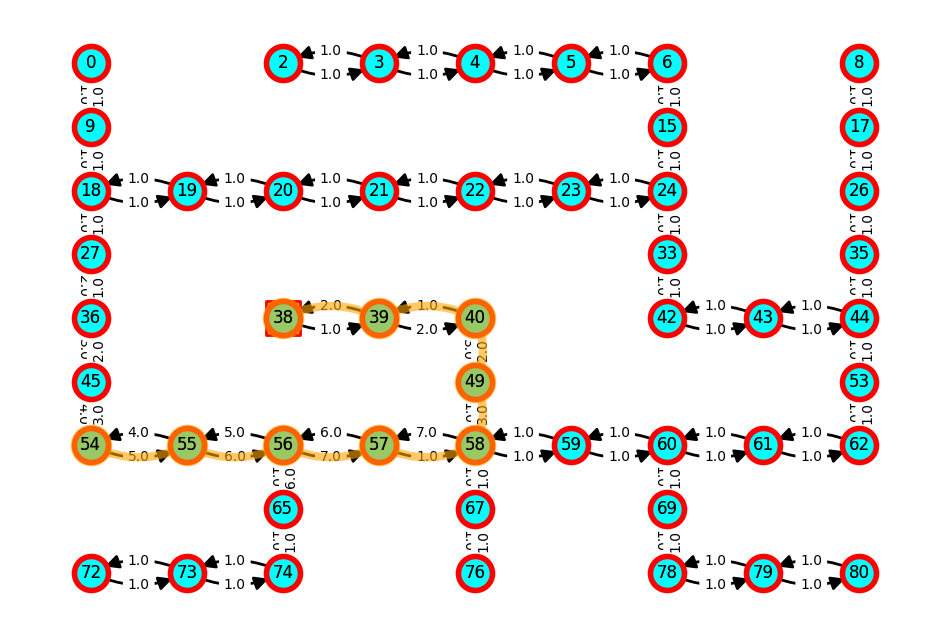

In [25]:
#
# 利用例
#   この利用例が動くように，上記にて dijkstra() や backtrack() を定義してください．
#

# DEBUG
graph_start = 54
closed_list = dijkstra(maze.graph_edgedict, maze.graph_target, graph_start)
route, total_cost = backtrack(closed_list, maze.graph_target, graph_start)

# Draw the Graph
fig2, ax2 = plt.subplots(1, 1, figsize=(12, 8), num=2, clear=True)

maze.draw_graph(highlight_path=route, closed_list=closed_list,
        show_weight=True, ax=ax2, nscale=0.5)

plt.show()

### 実行結果に対する説明と考察

E-1) では，AI-2) までの内容と変わったところがほとんどない．dijkstra関数，backtrack関数それぞれの引数に第三の引数として graph_start を渡しているのは，E-2) において使用するからである．

変更したところは，dijkstra関数では，open_list に最初に入れる状態を graph_start にしたことである．これは初期状態を入れれるようにするためである．
backtrack関数では，バックトラックの終了条件を bt_node_id != graph_start にしたことと，バックトラックの成功判定を bt_node_id == graph_start にしたことである．これはどちらも，ゴールよりも大きい初期状態から始まってもバックトラックできるようにするための判定である．

実際にゴールである 38 を超える初期値から始めてもゴールまでの道のりをバックトラックできている．

## E-2) (Extra-B) 迷路を探索しよう！！

### ソースコード

In [16]:
from ipywidgets import Button, Output, Label
from ipywidgets import GridspecLayout, Layout, HBox, VBox

if 'fig' in locals():
    fig.clear()
    plt.close(fig)
    del fig

# PLOTAREA(1): MAP
figarea = Output()
with figarea:

    fig, ax = plt.subplots(constrained_layout=True, figsize=(5, 4), num=3, clear=True)
    # fig.canvas.toolbar_position = 'bottom'
    maze.draw_maze(ax=ax)
    plt.show()

# PLOTAREA(2): CONTROLLER
buttons = GridspecLayout(2, 3)
_btn_param = {'width': '60px', 'height': '60px'}
buttons[0, 1] = Button(description='U', layout=Layout(**_btn_param))
buttons[1, 0] = Button(description='L', layout=Layout(**_btn_param))
buttons[1, 1] = Button(description='D', layout=Layout(**_btn_param))
buttons[1, 2] = Button(description='R', layout=Layout(**_btn_param))
    # note: callback functions will be assign after the robot is initialized.

txt_log1 = Label(value="History: ")
txt_log2 = Label(value='FPS: ')
btn_reset = Button(description='Reset', layout=Layout(width='80px', height='60px'))
btn_autorun = Button(description='AutoRun', disabled=True, layout=Layout(width='80px', height='60px'))
    # AutoRunボタンは無効化しています．(disabled=True)
    # 有効化だけしても意味はありません．次に掲載するプログラム例末尾のコメントを参考にしてください．

ui_panel = HBox([
    buttons,
    VBox([
        txt_log1,
        txt_log2,
        HBox([btn_reset, btn_autorun])
    ])
])

all_area = VBox([figarea, ui_panel])
    # VBox を HBox に変えると，地図の右側にコントローラが表示されます．
    # Vertical と Horizontal の違いです．

# Define robot, and assign event-callback functions.
robot = ebai.Robot('example/openmouthrobot.png', maze,
                   fig=fig, ax=ax, zoom=0.2,
                   output=txt_log1)
buttons[0, 1].on_click(robot.req_move_up)
buttons[1, 0].on_click(robot.req_move_left)
buttons[1, 1].on_click(robot.req_move_down)
buttons[1, 2].on_click(robot.req_move_right)
btn_reset.on_click(robot.req_reset)

robot.update_plot(no_wait=False)

# Display all widgets
display(all_area)

START [0, 0] / 0


In [17]:
import time

# Robot's action plan as Queue
# action_plan = deque([])
    # ロボットの行動計画を Queue に入れます．
    # - 適切なモジュールに置き換えれば，スレッドセーブ（他スレッドからも挿入可能）にもできます．
    #   (deque はスレッドセーフではない．その代わり，シングルスレッドで高速な動作を実現できることが多い．)
    # - この経路は，説明のため，適当に与えていますので，最善ではないかもしれません．念のため．
def mat_to_pos(pos):
    return pos[1] * 9 + pos[0]

def pos_to_mat(val):
    y = val // 9
    x = val % 9
    return (x, y)

def path_to_directions(path_vals):
    directions = []
    for i in range(len(path_vals) - 1):
        x1, y1 = pos_to_mat(path_vals[i])
        x2, y2 = pos_to_mat(path_vals[i+1])
        dx, dy = x2 - x1, y2 - y1

        if dx == 1 and dy == 0:
            directions.append('R')
        elif dx == -1 and dy == 0:
            directions.append('L')
        elif dx == 0 and dy == 1:
            directions.append('D')
        elif dx == 0 and dy == -1:
            directions.append('U')
        else:
            directions.append('?')  # 不明な移動（斜めや飛び越え）
    return directions


def robot_autorun(*args):
    # 関数外にある action_plan 変数を使います．
    # global action_plan

    cur_mat = robot._position
    cur_pos = mat_to_pos(cur_mat)
    closed_list = dijkstra(maze.graph_edgedict, maze.graph_target, cur_pos)
    route, total_cost = backtrack(closed_list, maze.graph_target, cur_pos)

    action_plan = deque(path_to_directions(route))

    # Refresh rate
    INTERVAL = 1.0 / 5.0   # [sec]
        # 画面更新のインターバルを決めておきます
        # - JupyterLab環境だと 10 FPS も出せたら万々歳・・・かな．
        # - なお，今回はロボットの速度は 1.0 [cell/frame] で固定しています．
        #   - 1 時刻フレームごとに，1マス進むの意味です．
        #   - 5 FPSなら，1秒に5マス進みます．言い換えると，0.2秒ごとに1マス進みます．
        #   - 滑らかに動くアニメーションのためには，画面上のキャラクターは1マス単位ではなく，
        #     より細かく移動中も描画したほうが良いですが・・・さすがに講義のレベルを超える
        #     プログラムになるので，今回は入れていません．（本実験の目的とも合致しませんし）

    # Dequeue from the action queue, wait a shorttime, and do the action
    _last_time = time.perf_counter()
    while len(action_plan) > 0:
        # waitしていることを除けば，どこかで見たような while ループでしょう．
        #      --> グラフ探索のループはどういう構造だったでしょうか？

        # Redraw: Message pump for the rendering thread
        fig.canvas.flush_events()
            # - 他スレッドへの意識なしにループすると，計算処理に CPU が100%利用されるため，
            #   処理優先度の低い描画処理が後回しになる --> ループが終わるまで描画されない
            #   (オペレーティングシステムのタイムスライス機構も思い出そう！)
            # - ほとんどの言語系では，sleep() 関数で代用できることも多いことは覚えておくとよい．
            #   --> 無限ループで異常にPCが重くなる時は，ループ内に sleep() を入れる!!

        #
        # wait timer
        #
        if (_interval := (time.perf_counter() - _last_time)) < INTERVAL:
            continue

        _last_time = time.perf_counter()
            # 次のタイマー待ちのため，ここで現在時刻を再入手します．
            # 5 FPS で描画をするなら，計算処理を含めて，0.2秒 (200 ms) しか使えません．

        # ---
        txt_log2.value = f'FPS: {1./_interval:.1f} FPS'
            # これは画面にFPSを表示するための処理．
            # タイマー処理に必須というわけではありません．

        #
        # Process: run your action
        #
        action = action_plan.popleft()
        robot.req_move(action)
            # キューから次のアクションを取り出し，ロボットに与えます．


# Test move
# robot_autorun()

# 参考：
# 上1行はコメントアウトして，以下の2行でボタンにイベントを割り付けてみるのも手です．
btn_autorun.on_click(robot_autorun)
btn_autorun.disabled = False
#   # 少し注意点を．
#   # - 結びつける関数（コールバック関数）は引数を受け取れるようにする必要があります．
#   #   (robot_autorun()関数定義で使いもしない引数 *arg が書いてあるのは，そのため．)
#   # - action_plan はキューなので，robot_autorun()が終わった後は空っぽです．
#   #   - GUIの上で再実行したいなら，キューに改めて挿入する必要があります．
#   #   - 例えば，ロボットの現在位置からゴールまで(再)探索する・・・とかです．

### 実行結果に対する説明と考察

E-1) における変更は，ここでロボットを任意の地点からオートランできるようにするためである．autorun をクリックされたときのロボットの状態を取得し，それを初期値をしてdijkstra関数やbacktrack関数に渡せればロボットがどこからでもゴールに到達することができる．

ebai.py ファイルにおいてロボットの状態が，

In [18]:
    def update_position(self, offset_x:int=0, offset_y:int=0):
        """
        Parameters
        ----------
        offset_x : int
            x方向の移動量
        offset_y : int
            y方向の移動量

        Note
        ----
        - 外部から呼び出すことは期待されていない．`req_XXX` を介して移動すること．
        - 移動に失敗した場合もその場所のコストを負う
        """
        assert np.abs(offset_x) <= 1
        assert np.abs(offset_y) <= 1

        _x = self._position[0] + offset_x
        _y = self._position[1] + offset_y
        xmax, ymax = self._maze.size()
        if (_x < 0) or (_y < 0) or (_x >= xmax) or (_y >= ymax):
            self._add_cost()
            return False

        if self._maze.maze_def[_y][_x] != 0:
            self._position[0] = _x
            self._position[1] = _y
            self._add_cost()
            return True

        self._add_cost()
        return False


上記のように管理されていることがわかる．よって robot._position で現在位置が取得できる．

また，mat_to_pos(pos)関数，pos_to_mat関数，path_to_directions関数はそれぞれ，タプル(現在位置)を数値(graph_start) に，数値をタプルに，配列(backtrackによる探索ルート)を文字(移動方向('U','D','R','L'))に変換する関数である．
これらは，扱う型の異なる関数のインターフェイスとして機能する．

## E-3) (Extra-C) A\* algorithm による探索の実装

### ソースコード

In [11]:
import heapq
import math

# A*アルゴリズムのためのデータクラス
@dataclass
class Astate:
    id: int
    cost: float
    # eval_score = f(n) = g(n) + h(n)
    eval_score: float
    parent_id: int

    # ヒープの優先順位は g(n) + h~(n) が小さい順
    def __lt__(a, b):
        a_sum = a.eval_score
        b_sum = b.eval_score
        if a_sum != b_sum:
            return a_sum < b_sum

def pos_to_mat(val):
    y = val // 9
    x = val % 9
    return (x, y)

In [12]:
# マンハッタン距離
# def heuristic_func(node_a, node_b):
#     ax, ay = pos_to_mat(node_a)
#     bx, by = pos_to_mat(node_b)
#     return abs(ax - bx) + abs(ay - by)

# ユークリッド距離
# def heuristic_func(node_a, node_b):
#     ax, ay = pos_to_mat(node_a)
#     bx, by = pos_to_mat(node_b)
#     return math.sqrt((ax - bx)**2 + (ay - by)**2)

# マンハッタン距離＋bias ver1
def heuristic_func(node_a, node_b):
    ax, ay = pos_to_mat(node_a)
    bx, by = pos_to_mat(node_b)
    return abs(ax - bx) + abs(ay - by)**3

# マンハッタン距離＋bias ver2
# def heuristic_func(node_a, node_b, cost):
#     ax, ay = pos_to_mat(node_a)
#     bx, by = pos_to_mat(node_b)
#     return abs(ax - bx) + abs(ay - by)**3 + cost**1.5

# ユークリッド距離＋指数
# def heuristic_func(node_a, node_b):
#     ax, ay = pos_to_mat(node_a)
#     bx, by = pos_to_mat(node_b)
#     distance = math.sqrt((ax - bx)**2 + (ay - by)**2)
#     return math.pow(1.6, distance)

# ユークリッド距離の自然対数とマンハッタン距離を合計した値
# def heuristic_func(node_a, node_b):
#     ax, ay = pos_to_mat(node_a)
#     bx, by = pos_to_mat(node_b)
#     manhattan = abs(ax - bx) + abs(ay - by)
#     euclidean = math.sqrt((ax - bx)**2 + (ay - by)**2)
#     h_score = euclidean + manhattan
#     return h_score

In [13]:
def Astar(graph_edgedict, graph_target, graph_start):
    open_list = []
    heapq.heapify(open_list)
    heapq.heappush(open_list, Astate(graph_start, cost=0, eval_score = heuristic_func(graph_start, graph_target), parent_id=-1))
    closed_list = dict()

    loop_count = 0
    while len(open_list) > 0 and loop_count < 200:
        loop_count += 1
        cur_state = heapq.heappop(open_list)

        # 処理5の改造　取り出したidがゴールなら探索終了
        if cur_state.id == graph_target:
            closed_list[cur_state.id] = cur_state
            break

        closed_list[cur_state.id] = cur_state


        candidate_state_nodes = graph_edgedict[cur_state.id]

        for _dst_id, _weight in candidate_state_nodes:
            g_new = cur_state.cost + _weight
            h_new = heuristic_func(_dst_id, graph_target)
            candidate_state = Astate(
                id=_dst_id,
                cost=g_new,
                eval_score=g_new+h_new,
                parent_id=cur_state.id
            )

            if candidate_state.id in closed_list:
                # 処理7-1の改造　探索してきた経路が最短とは限らないから，取り出す作業
                if g_new < closed_list.get(candidate_state.id, Astate(id=-1, cost=-1, eval_score = 0, parent_id=-9)).cost:
                    # dict型の削除方法
                    del closed_list[candidate_state.id]
                    candidate_state.eval_score = g_new + h_new 
                    heapq.heappush(open_list, candidate_state)
                continue

            _exist_state = [x for x in open_list if x.id == candidate_state.id]
            _exist_state = _exist_state[0] if _exist_state else None
            if _exist_state is None:
                heapq.heappush(open_list, candidate_state)
            # A* では，g(n)+h(n) で評価する
            elif candidate_state.eval_score < _exist_state.eval_score:
                open_list.remove(_exist_state)
                heapq.heappush(open_list, candidate_state)
            else:
                pass

    return closed_list

In [14]:
def A_backtrack(closed_list, graph_target, graph_start):
    route = deque([])
    bt_node_id = graph_target
    bt_node_cost = 0

    while bt_node_id != graph_start:
        route.appendleft(bt_node_id)
        bt_node_id = closed_list.get(bt_node_id, Astate(id=-1, cost=-1, eval_score = 0, parent_id=-9)).parent_id
        bt_node_cost += closed_list.get(bt_node_id, Astate(id=-1, cost=-1, eval_score = 0, parent_id=-9)).cost

    if bt_node_id == graph_start:
        pass
    else:
        # Backtracking失敗
        print(f'Backtracking: Failed: Route = {list(route)}?')

    route.appendleft(graph_start)
    return list(route), bt_node_cost

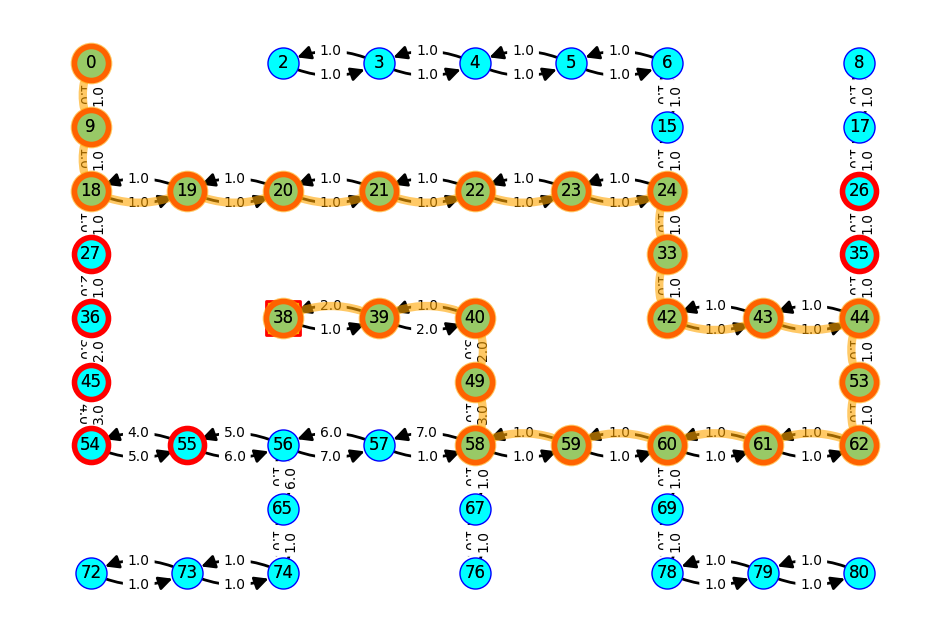

In [16]:
# DEBUG
graph_start = 0
closed_list = Astar(maze.graph_edgedict, maze.graph_target, graph_start)
route, total_cost = A_backtrack(closed_list, maze.graph_target, graph_start)

# Draw the Graph
fig2, ax2 = plt.subplots(1, 1, figsize=(12, 8), num=2, clear=True)

maze.draw_graph(highlight_path=route, closed_list=closed_list,
        show_weight=True, ax=ax2, nscale=0.5)

plt.show()

### 実行結果に対する説明と考察

dijkstraアルゴリズムを少し変形させることによりA*アルゴリズムを設計することができる．
State クラスは eval_score を設定するためにAstateという新しいデータクラスを設定した．eval_score は g(n) + h(n) のことである．
A*アルゴリズムは評価値の計算に heuristic な値を使用するので，closed_list に格納したとしてもそれが最短の経路であることは保証されない．
よって，コストの低い経路ができ次第，closed_list から open_list に移動させる．

#### heuristic_func の検討
startを0としたときを考える．斜め移動を許容しないグラフであるので，マンハッタン距離を h(n) に使用してみる．すると，無駄なノードの探索数が18個存在した．
そこでお試しとしてユークリッド距離を使用してみたところ，無駄なノードの探索数は21個にまで上昇した．これは，グラフの斜めの方向のコストが減少したことによって，より広く探索できるようになったためである．
ゴールからみて遠くに存在するノードの探索数を減らしたかったため，先ほどのユークリッド距離を指数にして計算してみた．すると底を1.7に設定したときに，無駄なノードの探索数が最小となり，それは18個であった．
次に，マンハッタン距離とユークリッド距離を足し合わせる方法にした．すると，無駄なノードの探索数は14個となった．ダイクストラ法の無駄なノードの探索数が25個であったので，かなり効率よく探索できている．

次の方法はあまり美しくないが，今回扱っているグラフの特性を活かしてマンハッタン距離のy方向のみを過大評価する方法をとった．y方向のみを3乗すると，無駄なノードの探索数は7個まで少なくなった．これは，ノード数最短の経路とコスト最小の経路がちょうど同じ y において分岐しているためうまくいった．
また，cost を1.5乗にして探索をしてみた(実際はh(n)にて1.5乗でg(n)分で加算されるため　cost**1.5 + cost)．すると，無駄なノードの探索数は5個まで減少した．
この時，startを54,55に設定したときのみ最短経路をたどれない．